In [271]:
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
import json
import string
import re
import time
from collections import defaultdict

from array import array
import math
import collections
from numpy import linalg as la
import pandas as pd

import gensim.downloader as api 
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iliasasskali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [213]:
# Read json and store the text of each tweet into a list
def read_json(docs_path):
    with open(docs_path) as fp:
        lines = json.load(fp)

    print("Total number of tweets in the dataset: {}".format(len(lines)))
    return lines

docs_path = 'inputs/dataset_tweets_WHO.txt'
lines = read_json(docs_path)

tweets = []
for tweetId in lines:
    tweets.append(lines[str(tweetId)]["full_text"])

Total number of tweets in the dataset: 2399


In [214]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

url_pattern = re.compile(r'https?://\S+|www\.\S+')

def remove_urls(line):
    return url_pattern.sub(r'', line)

def remove_emojis(line):
    return emoji_pattern.sub(r'', line)

def build_terms(line):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    line = line.encode("ascii", "ignore") # Remove unicode characters
    line = line.decode()
    line = line.lower() ## Transform to lowercase
    line = remove_emojis(line) ## Remove emojis, before tokenizing to delete emojis not separated by space with a word
    line = remove_urls(line) ## Remove urls
    line = line.split() ## Tokenize the text to get a list of terms
    line = [w for w in line if w not in stop_words]  ## eliminate the stopwords
    line = [w for w in line if w[0]!='&' and w[-1]!=';'] ## Remove HTML symbol entity codes
    line = [w.strip(string.punctuation.replace('#', '').replace('@', '')) for w in line] ## Remove punctuation except # and @
    line = [stemmer.stem(w) for w in line if w!=''] ## perform stemming and remove empty words
    return line

In [215]:
# Execute to see first 10 original and processed tweets
for tweet in tweets[:10]:
    print("Original tweet:\n" + tweet + "\n")
    print("Processed tweet:\n" + str(build_terms(tweet)) + "\n")

Original tweet:
It's International Day for Disaster Risk Reduction

#OpenWHO has launched a multi-tiered core curriculum to help equip you with the competencies needed to work within public health emergency response.

Start learning today &amp; be #Ready4Response:
👉 https://t.co/hBFFOF0xKL https://t.co/fgZY22RWuS

Processed tweet:
['intern', 'day', 'disast', 'risk', 'reduct', '#openwho', 'launch', 'multi-ti', 'core', 'curriculum', 'help', 'equip', 'compet', 'need', 'work', 'within', 'public', 'health', 'emerg', 'respons', 'start', 'learn', 'today', '#ready4respons']

Original tweet:
#COVID19 has shown how health emergencies and disasters affect entire communities – especially those with weak health systems, and vulnerable populations like migrants, indigenous peoples, and those living in fragile humanitarian conditions. https://t.co/jpUQpnu0V1

Processed tweet:
['#covid19', 'shown', 'health', 'emerg', 'disast', 'affect', 'entir', 'commun', 'especi', 'weak', 'health', 'system', 'vulner'

PART 2: INDEXING AND EVALUATION

In [216]:
# 1. Inverted index:
def create_index(lines):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of json tweets
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    tweet_index = {}  # dictionary to map tweet ids (starting from 0) to their info
    for tweetId in lines:  # lines contain all tweets, whith the id as key
        full_tweet = lines[str(tweetId)]
        
        tweet_id = full_tweet["id"] # id 
        tweet = full_tweet["full_text"] # Tweet
        username = full_tweet["user"]["screen_name"] # Username
        date = full_tweet["created_at"] # Date
        hashtags = full_tweet["entities"]["hashtags"] # Hashtags
        likes = full_tweet["favorite_count"] # Likes
        retweets = full_tweet["retweet_count"] # Retweets
        url = f"https://twitter.com/{username}/status/{tweet_id}" # Url
        terms = build_terms(tweet)
        
        # Store tweet info in the dictonary to retrieve it faster when searching
        tweet_index[tweetId] = {}
        tweet_index[tweetId]["tweet"] = tweet
        tweet_index[tweetId]["username"] = username
        tweet_index[tweetId]["date"] = date
        tweet_index[tweetId]["hashtags"] = hashtags
        tweet_index[tweetId]["likes"] = likes
        tweet_index[tweetId]["retweets"] = retweets
        tweet_index[tweetId]["url"] = url

        current_page_index = {}

        for position, term in enumerate(terms): # Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                current_page_index[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[tweetId, array('I',[position])] 
            
        # Merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
                            
    return index, tweet_index


In [217]:
# Index creation and test
start_time = time.time()
index, tweet_index = create_index(lines)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

print("Index results for the term 'researcher': {}\n".format(index['international']))
print("First 10 Index results for the term 'research': \n{}".format(index['intern'][:10]))

Total time to create the index: 1.87 seconds
Index results for the term 'researcher': []

First 10 Index results for the term 'research': 
[['0', array('I', [0])], ['2', array('I', [0])], ['35', array('I', [1])], ['262', array('I', [0])], ['273', array('I', [0])], ['277', array('I', [0])], ['278', array('I', [1])], ['280', array('I', [1])], ['299', array('I', [0])], ['338', array('I', [0])]]


In [218]:
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

In [219]:
# Test by inserting a query
print("Insert your query (i.e.: Computer Science):\n")
query = input()
docs = search(query, index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print("page_id= {} - tweet: {}".format(d_id, tweet_index[d_id]["tweet"]))

Insert your query (i.e.: Computer Science):


Sample of 10 results out of 3 for the searched query:

page_id= 61 - tweet: RT @WHOPhilippines: Vaccines can’t stop #COVID19 alone, but by doing it all we can help protect ourselves and our loved ones against COVID-…
page_id= 200 - tweet: 🆕 WHO clinical case definition for post #COVID19 condition, also called 'long COVID' https://t.co/WoiLcwsgJX https://t.co/Z0olrHlWPC
page_id= 1561 - tweet: If you have recovered from #COVID19 but are still experiencing certain symptoms you could have post COVID-19 condition or "long COVID". What are these symptoms? How long do they last and are there any treatment options? Dr @diazjv explains in #ScienceIn5 ⬇️ https://t.co/vtDiBhZsJE


In [220]:
# 2. Make a proposal of 5 queries that will be used to evaluate your search engine
queries = [
    "covid pandemic",
    "international disaster",
    "ritmo de vacunacion",
    "percentage de hospitalizados",
    "mental health"
]
top = 3 # Number of tweets to show
for query in queries:
    docs = search(query, index) # obtain the tweets resulting of such query
    print("\n======================\nSample of {} results out of {} for the query {}:\n".format(top, len(docs), query))
    for d_id in docs[:top]:
        print("page_id= {} - tweet: {}".format(d_id, tweet_index[d_id]["tweet"]))


Sample of 3 results out of 236 for the query covid pandemic:

page_id= 963 - tweet: @DrTedros @IMFNews @WorldBank @wto @G7 "Even as we respond to the #COVID19 pandemic, we must learn the lessons it's teaching us. One of the most clear is the need for new, powerful systems &amp; tools for 🌍 surveillance, to collect, analyse &amp; disseminate data on outbreaks with the potential to become pandemics"-@DrTedros
page_id= 1087 - tweet: "Most recently, the @g20org established a High-Level Independent Panel on Financing the Global Commons for Pandemic Preparedness and Response."-@DrTedros 
https://t.co/5U2cYU5mDm
page_id= 2013 - tweet: The Emergency Committee on #COVID19 reconvenes every 3 months to evaluate the evolution of the pandemic &amp; make recommendations to WHO &amp; countries on how to respond to the Public Health Emergency of International Concern.

Previous recommendations: https://t.co/cA4FCWWUqJ https://t.co/bmkZN64X50

Sample of 3 results out of 78 for the query international 

In [221]:
# 3. Apply a TF-IDF ranking to your results.
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of tweets
    num_documents -- total number of tweets
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents
    df = defaultdict(int)  # document frequencies of terms in the corpus
    tweet_index = defaultdict(str)
    idf = defaultdict(float)

    for tweetId in lines:
        full_tweet = lines[str(tweetId)]
        
        tweet_id = full_tweet["id"] # id 
        tweet = full_tweet["full_text"] # Tweet
        username = full_tweet["user"]["screen_name"] # Username
        date = full_tweet["created_at"] # Date
        hashtags = full_tweet["entities"]["hashtags"] # Hashtags
        likes = full_tweet["favorite_count"] # Likes
        retweets = full_tweet["retweet_count"] # Retweets
        url = f"https://twitter.com/{username}/status/{tweet_id}" # Url
        terms = build_terms(tweet)
        
        # Store tweet info in the dictonary to retrieve it faster when searching
        tweet_index[tweetId] = {}
        tweet_index[tweetId]["tweet"] = tweet
        tweet_index[tweetId]["username"] = username
        tweet_index[tweetId]["date"] = date
        tweet_index[tweetId]["hashtags"] = hashtags
        tweet_index[tweetId]["likes"] = likes
        tweet_index[tweetId]["retweets"] = retweets
        tweet_index[tweetId]["url"] = url

        current_page_index = {}
        for position, term in enumerate(terms):
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[tweetId, array('I',[position])]

        # Normalize term frequencies
        norm = 0
        for term, posting in current_page_index.items():
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # Calculate the tf and df weights
        for term, posting in current_page_index.items():
            tf[term].append(np.round(len(posting[1])/norm,4))
            df[term] += 1 # increment DF for current term

        # Merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, tweet_index


In [222]:
start_time = time.time()
num_documents = len(lines)
index, tf, df, idf, tweet_index = create_index_tfidf(lines, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))


Total time to create the index: 116.18 seconds


In [223]:

def rank_documents(terms, docs, index, idf, tf, tweet_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    tweet_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 

    query_norm = sum(query_terms_count.values())
    for termIndex, term in enumerate(terms):  # termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):           
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    
    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)

    return result_docs


In [224]:

def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf, tweet_index)
    return ranked_docs

In [225]:
print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs = search_tf_idf(query, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("page_id= {} - page_title: {}".format(d_id, tweet_index[d_id]))

Insert your query (i.e.: Computer Science):


Top 10 results out of 3 for the searched query:

page_id= 200 - page_title: {'tweet': "🆕 WHO clinical case definition for post #COVID19 condition, also called 'long COVID' https://t.co/WoiLcwsgJX https://t.co/Z0olrHlWPC", 'username': 'WHO', 'date': 'Thu Oct 07 12:28:10 +0000 2021', 'hashtags': [{'text': 'COVID19', 'indices': [40, 48]}], 'likes': 723, 'retweets': 373, 'url': 'https://twitter.com/WHO/status/1446089970758860801'}
page_id= 61 - page_title: {'tweet': 'RT @WHOPhilippines: Vaccines can’t stop #COVID19 alone, but by doing it all we can help protect ourselves and our loved ones against COVID-…', 'username': 'WHO', 'date': 'Mon Oct 11 04:39:10 +0000 2021', 'hashtags': [{'text': 'COVID19', 'indices': [40, 48]}], 'likes': 0, 'retweets': 71, 'url': 'https://twitter.com/WHO/status/1447421491428143106'}
page_id= 1561 - page_title: {'tweet': 'If you have recovered from #COVID19 but are still experiencing certain symptoms you could have pos

EVALUATION

In [226]:
search_results = pd.read_csv("inputs/test_predictions.csv")
search_results.head()
print("The ground truth of our dataset is composed of {} Relevance Levels: {}" .format(len(search_results["y_true"].unique()), sorted(search_results["y_true"].unique())))
search_results["bin_y_true"] = np.where(search_results["y_true"] >= 2.0, 1, 0)
search_results.head()
search_results["bin_y_true"] = search_results["y_true"].apply(lambda y: 1 if y >=2 else 0)
search_results.head()

The ground truth of our dataset is composed of 5 Relevance Levels: [0.0, 1.0, 2.0, 3.0, 4.0]


,q_id,doc_id,predicted_relevance,y_true,bin_y_true
0,0,0,-0.637926,2.0,1
1,0,1,-0.824241,1.0,0
2,0,2,-1.358856,3.0,1
3,0,3,-0.096755,1.0,0
4,0,4,-1.268338,0.0,0


In [227]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = sum(y_true == 1)
    return float(relevant) / k

In [228]:
# Check for query 0

current_query = 0
current_query_res = search_results[search_results["q_id"] == current_query] 
k=5

print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["bin_y_true"], current_query_res["predicted_relevance"], k)))
print("\nCheck on the dataset sorted by score:\n")
current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
k=3
print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["bin_y_true"], current_query_res["predicted_relevance"], k)))
print("\nCheck on the dataset sorted by score:\n")
current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
k=10
print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["bin_y_true"], current_query_res["predicted_relevance"], k)))
print("\nCheck on the dataset sorted by score:\n")
current_query_res.sort_values("predicted_relevance", ascending=False).head(k)



==> Precision@5: 0.6


Check on the dataset sorted by score:

==> Precision@3: 0.6666666666666666


Check on the dataset sorted by score:

==> Precision@10: 0.6


Check on the dataset sorted by score:



,q_id,doc_id,predicted_relevance,y_true,bin_y_true
88,0,88,1.705258,2.0,1
114,0,114,1.116369,2.0,1
63,0,63,1.096797,1.0,0
34,0,34,1.084367,1.0,0
86,0,86,1.082985,3.0,1
47,0,47,1.081464,0.0,0
55,0,55,1.075457,2.0,1
76,0,76,1.063326,3.0,1
17,0,17,1.016901,2.0,1
58,0,58,0.906784,1.0,0


In [229]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    gtp = np.sum(y_true == 1) 
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])            
    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i +=1
            prec_at_i += n_relevant_at_i/(i+1)
    return prec_at_i/gtp

In [230]:
print(avg_precision_at_k(np.array(current_query_res["bin_y_true"]), np.array(current_query_res["predicted_relevance"]), 150))
from sklearn.metrics import average_precision_score
k = 150
temp = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
average_precision_score(np.array(temp["bin_y_true"]), np.array(temp["predicted_relevance"][:k]))

0.5021658287937124


0.5021658287937125

In [237]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["q_id"].unique(): #loop over all query id
        curr_data = search_res[search_res["q_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["bin_y_true"]), np.array(curr_data["predicted_relevance"]),k)) #append average precision for current query
    return np.sum(avp)/len(avp) # return mean average precision

In [239]:
map_k = map_at_k(search_results, 10)
map_k

0.1752575969478396

In [240]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true,order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    return 1/(np.argmax(y_true == 1)+1) # hint: to get the position of the first relevant document use "np.argmax"

In [241]:
y_true = np.array([0,1,0,1,1])
score = np.array([0.9, 0.5, 0.6, 0.7, 0.2])
rr_at_k(y_true, score,5)

0.5

In [243]:
current_query = 8
current_query_res = search_results[search_results["q_id"] == current_query] 
current_query_res.sort_values("predicted_relevance", ascending=False).head(10)

,q_id,doc_id,predicted_relevance,y_true,bin_y_true
1067,8,52,0.115248,0.0,0
1039,8,24,-0.046405,0.0,0
1028,8,13,-0.404693,0.0,0
1051,8,36,-0.493206,1.0,0
1066,8,51,-0.701708,1.0,0
1034,8,19,-0.755329,0.0,0
1015,8,0,-0.802263,2.0,1
1025,8,10,-0.827835,0.0,0
1031,8,16,-0.836900,0.0,0
1022,8,7,-0.878972,0.0,0


In [245]:
labels = np.array(search_results[search_results['q_id'] == 8]["bin_y_true"])
scores = np.array(search_results[search_results['q_id'] == 8]["predicted_relevance"])
np.round(rr_at_k(labels, scores, 10),4)

0.1429

In [247]:
mrr = {}
for k in [3,5,10]:
    RRs = []
    for q in search_results['q_id'].unique(): # loop over all query ids
        labels = np.array(search_results[search_results['q_id'] == q]["bin_y_true"]) # get labels for current query
        scores = np.array(search_results[search_results['q_id'] == q]["predicted_relevance"]) # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k)) # append RR for current query
    mrr[k] = np.round(float(sum(RRs)/len(RRs)),4) # Mean RR at current k

In [248]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** y_true - 1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k) / dcg_max,4)

In [249]:
q_id = 0
k = 10
labels = np.array(search_results[search_results['q_id'] == q_id]["y_true"])
scores = np.array(search_results[search_results['q_id'] == q_id]["predicted_relevance"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
print("ndcg@{} for query with q_id={}: {}".format(k,q_id,ndcg_k))


ndcg@10 for query with q_id=0: 0.4392


In [250]:
ndcgs = []
k=10
for q in search_results['q_id'].unique():
    labels = np.array(search_results[search_results['q_id'] == q]["y_true"])
    scores = np.array(search_results[search_results['q_id'] == q]["predicted_relevance"])
    ndcgs.append(np.round(ndcg_at_k(labels, scores, k),4))

avg_ndcg = np.round(float(sum(ndcgs)/len(ndcgs)),4)
print("Average ndcg@{}: {}".format(k,avg_ndcg))

Average ndcg@10: 0.4646


Word2vec:

In [252]:
# First time running this, it will take awhile (over 10 minutes depending on downloading speed)
# The model (word2vec-google-news-300) is trained on Google News (about 100 billion words).
word2vec_model = api.load("word2vec-google-news-300") # Load Word2Vec language model

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [362]:
def vector_representation(tweet):
    """
    Represents a tweet as a vector computing the average of the word2vec representation of each word
    input: tweet
    output: vector representation of the tweet
    """
    dim = len(word2vec_model['good'])
    word_vectors = []
    words = build_terms(tweet)
    for word in words:
        if word in word2vec_model:
            word_vector = word2vec_model[word]
            word_vectors.append(word_vector)
        else:
            word_vectors.append(np.zeros(dim))
    if len(word_vectors) > 1:
        return np.mean(word_vectors, axis=0)
    return word_vectors

In [363]:
# Vector representation test
vector_representation("international corona virus")

array([-0.0530599 ,  0.09318002, -0.03125   ,  0.        , -0.10986328,
        0.09505208,  0.06656901, -0.02956645,  0.02246094, -0.08886719,
       -0.13490804, -0.07177734, -0.00813802, -0.07128906,  0.0154012 ,
        0.21354167, -0.05399577,  0.02539062,  0.11832682, -0.07967122,
       -0.01072184, -0.05859375,  0.12207031, -0.13248698, -0.05196126,
       -0.06066895, -0.05731201,  0.05823771, -0.16699219,  0.04231771,
       -0.10441081, -0.17073568, -0.09391276,  0.06901042, -0.01928711,
       -0.11865234, -0.02034505, -0.05834961,  0.03938802,  0.06738281,
        0.01033529, -0.21419271, -0.14908854, -0.04573568,  0.04573568,
       -0.19938151, -0.03808594, -0.09773763,  0.10611979,  0.18326823,
       -0.08886719, -0.1546224 ,  0.0625    ,  0.06050618, -0.03430176,
        0.07613118,  0.19889323, -0.07014974, -0.11751302, -0.03446452,
       -0.03597005,  0.00179036, -0.10986328,  0.03938802,  0.01204427,
        0.0534668 , -0.05989583, -0.11222331,  0.02880859,  0.04

In [386]:
def plot_tweets(lines):
    """
    Represents the tweets in a two-dimensional scatter plot.
    """
    word_representations = np.empty((0,300), dtype='f')
    word_labels = []

    for tweetId in lines:
        full_tweet = lines[str(tweetId)]
        
        tweet = full_tweet["full_text"] # Tweet
        vector_rep = vector_representation(tweet)
        try:
            word_representations = np.append(word_representations, np.array([vector_rep]), axis=0)
        except:
            continue
        word_labels.append(tweetId)

        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(word_representations)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/Users/iliasasskali/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/iliasasskali/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


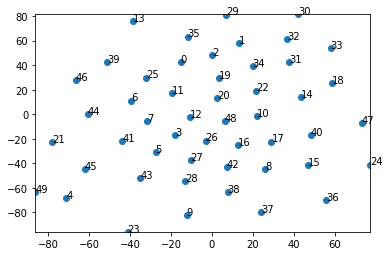

In [402]:
# Testing the plot function for 50 tweets, if all tweets are used the label will hide the value and the plot won't look good
sliced_lines = dict(itertools.islice(lines.items(), 50))
plot_tweets(sliced_lines)